In [31]:
import sys
sys.path
sys.path.append('../')

In [32]:
import actlearn as al 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
import torch
from sklearn.metrics import f1_score, accuracy_score
import torch.nn.functional as F
import os
import glob
import torchvision.transforms as transforms
import random

In [48]:
class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        
        # Всего один сверточный слой + один полносвязный
        self.conv = nn.Conv2d(1, 8, kernel_size=3, padding=1)  # [8, 256, 256]
        self.pool = nn.MaxPool2d(16)  # 256 -> 16 (большой пулинг)
        
        self.flat = nn.Flatten()
        self.fc = nn.Linear(8 * 16 * 16, num_classes)  # 8*16*16 = 2048

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))  # [batch, 8, 16, 16]
        x = self.flat(x)  # [batch, 2048]
        x = self.fc(x)    # [batch, num_classes]
        return x

    def predict_proba(self, X):
        logits = self(X)
        return F.softmax(logits, dim=1)
CNN = CNN()

In [34]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

def load_images_from_folder_shuffled(base_path, seed=42):
    images = []
    labels = []
    
    classes = sorted([d for d in os.listdir(base_path) 
                     if os.path.isdir(os.path.join(base_path, d))])
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
    
    print(f"Найдены классы: {classes}")
    print(f"Сопоставление: {class_to_idx}")
    
    # Собираем все данные
    all_data = []
    for class_name in classes:
        class_dir = os.path.join(base_path, class_name)
        image_paths = glob.glob(os.path.join(class_dir, "*.jpg"))
        
        print(f"Класс '{class_name}': {len(image_paths)} изображений -> индекс {class_to_idx[class_name]}")
        
        for img_path in image_paths:
            all_data.append((img_path, class_to_idx[class_name]))
    
    # ШАФФЛИНГ данных
    random.seed(seed)
    random.shuffle(all_data)
    print(f"Всего изображений: {len(all_data)}")
    print(f"Первые 5 элементов после шаффла: {all_data[:5]}")
    
    # Загружаем изображения в перемешанном порядке
    for i, (img_path, label) in enumerate(all_data):
        try:
            image = Image.open(img_path)
            tensor = transform(image)
            images.append(tensor)
            labels.append(label)
        except Exception as e:
            print(f"Ошибка при загрузке {img_path}: {e}")
    
    return images, labels, classes

      

In [37]:
train_images, train_labels, classes = load_images_from_folder_shuffled("data_AL/BrainTumourMRI/Training")
train_data = torch.stack(train_images)
train_labels = torch.tensor(train_labels)
print(train_data.shape, train_labels.shape)

Найдены классы: ['glioma', 'meningioma', 'notumor', 'pituitary']
Сопоставление: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Класс 'glioma': 1321 изображений -> индекс 0
Класс 'meningioma': 1339 изображений -> индекс 1
Класс 'notumor': 1595 изображений -> индекс 2
Класс 'pituitary': 1457 изображений -> индекс 3
Всего изображений: 5712
Первые 5 элементов после шаффла: [('data_AL/BrainTumourMRI/Training/notumor/Tr-no_0668.jpg', 2), ('data_AL/BrainTumourMRI/Training/pituitary/Tr-pi_1060.jpg', 3), ('data_AL/BrainTumourMRI/Training/pituitary/Tr-pi_0782.jpg', 3), ('data_AL/BrainTumourMRI/Training/meningioma/Tr-me_1152.jpg', 1), ('data_AL/BrainTumourMRI/Training/pituitary/Tr-pi_0145.jpg', 3)]
torch.Size([5712, 1, 256, 256]) torch.Size([5712])


In [35]:
test_images, test_labels, classes = load_images_from_folder_shuffled("data_AL/BrainTumourMRI/Testing")
test_data = torch.stack(test_images)
test_labels = torch.tensor(test_labels)
print(test_data.shape, test_labels.shape)

Найдены классы: ['glioma', 'meningioma', 'notumor', 'pituitary']
Сопоставление: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Класс 'glioma': 300 изображений -> индекс 0
Класс 'meningioma': 306 изображений -> индекс 1
Класс 'notumor': 405 изображений -> индекс 2
Класс 'pituitary': 300 изображений -> индекс 3
Всего изображений: 1311
Первые 5 элементов после шаффла: [('data_AL/BrainTumourMRI/Testing/meningioma/Te-meTr_0003.jpg', 1), ('data_AL/BrainTumourMRI/Testing/meningioma/Te-me_0280.jpg', 1), ('data_AL/BrainTumourMRI/Testing/pituitary/Te-pi_0276.jpg', 3), ('data_AL/BrainTumourMRI/Testing/glioma/Te-gl_0022.jpg', 0), ('data_AL/BrainTumourMRI/Testing/meningioma/Te-me_0064.jpg', 1)]
torch.Size([1311, 1, 256, 256]) torch.Size([1311])


In [36]:
alpha = 1
def reduce_dataset(X, y, alpha):
    n_samples = len(X)
    n_keep = int(alpha * n_samples)

    return X[:n_keep], y[:n_keep]

In [38]:
train_data, train_labels = reduce_dataset(train_data, train_labels, alpha)
test_data, test_labels = reduce_dataset(test_data, test_labels, alpha)
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

torch.Size([5712, 1, 256, 256]) torch.Size([5712])
torch.Size([1311, 1, 256, 256]) torch.Size([1311])


In [57]:
AL = al.ActiveLearning(CNN, train_data, train_labels, test_data, test_labels, 
                       strategy="margin", al_type="incremental", init_size=128, 
                       update_size=128, batch_size=128, metric="f1", logs=True, skip=True)

AL TRAINING STARTED (incremental margin)
Training AL: incremental margin | Доля: 2.241
Training AL: incremental margin | Доля: 4.342
Training AL: incremental margin | Доля: 6.443
Training AL: incremental margin | Доля: 8.543
Training AL: incremental margin | Доля: 10.644
Training AL: incremental margin | Доля: 12.745
Training AL: incremental margin | Доля: 14.846
Training AL: incremental margin | Доля: 16.947
Training AL: incremental margin | Доля: 19.048
Training AL: incremental margin | Доля: 21.148
Training AL: incremental margin | Доля: 23.249
Training AL: incremental margin | Доля: 25.350
Training AL: incremental margin | Доля: 27.451
Training AL: incremental margin | Доля: 29.552
Training AL: incremental margin | Доля: 31.653
Training AL: incremental margin | Доля: 33.754
Training AL: incremental margin | Доля: 35.854
Training AL: incremental margin | Доля: 37.955
Training AL: incremental margin | Доля: 40.056
Training AL: incremental margin | Доля: 42.157
Training AL: incrementa

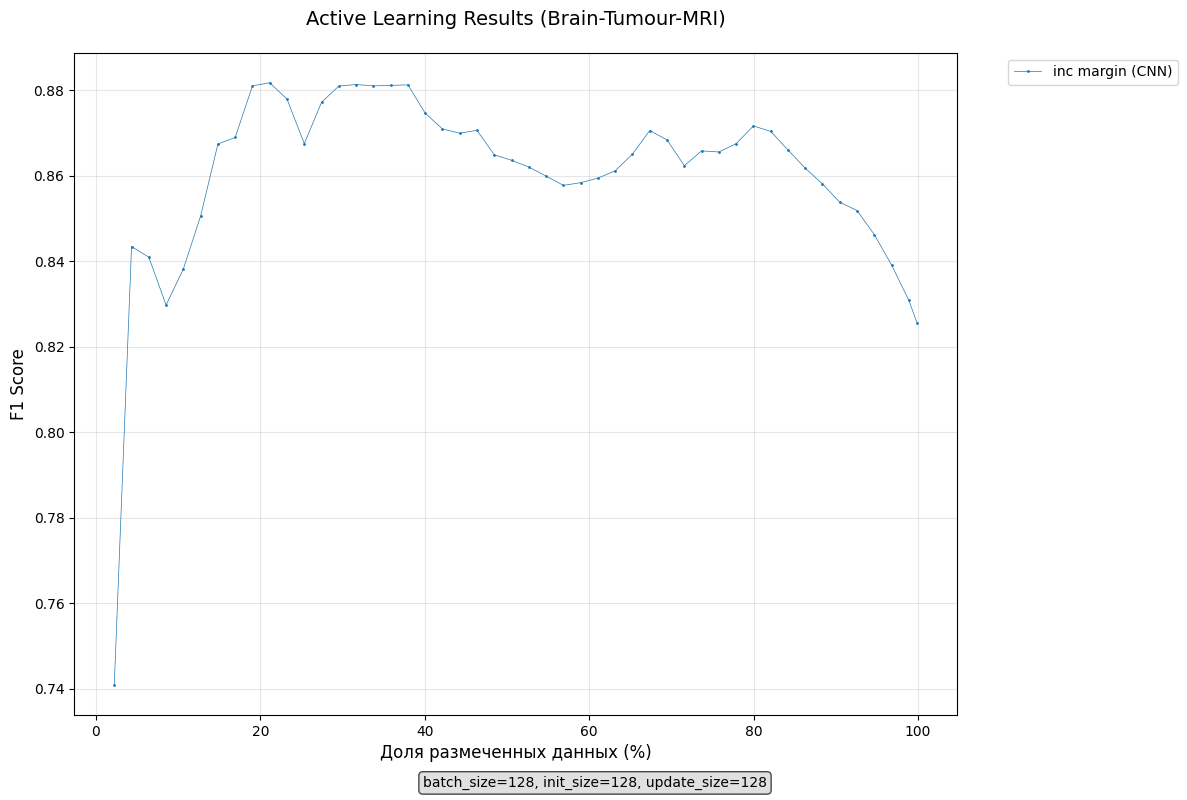

<Figure size 640x480 with 0 Axes>

In [58]:
AL.fit(stop_ratio=1)
al.plot_active_learning_results_many(AL, dataset_name="Brain-Tumour-MRI")